In [137]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as pl
import torch.nn.functional as F
import torchvision.models as models

In [138]:
from PIL import Image
from torchvision import transforms

In [139]:
from Models.CNN_model import CNN
from Models.VGG19_model import VGG19

In [140]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [141]:
cnn = CNN()
cnn.load_state_dict(torch.load("../assets/cnn_model.pth", map_location=device))
cnn.eval()

CNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=12544, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=4, bias=True)
  )
)

In [142]:
original_vgg19_model = models.vgg19(weights="VGG19_Weights.DEFAULT")
vgg = VGG19(original_vgg19_model)
vgg.load_state_dict(torch.load("../assets/vgg19_transfer.pth", map_location=device))
vgg.eval()

VGG19(
  (original_vgg19_model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)

In [212]:
image_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        # transforms.Normalize(mean = [0.1855, 0.1855, 0.1855], std = [0.2003, 0.2003, 0.2004])
    ]
)

In [213]:
def prepare_image(image_path: str) -> torch.Tensor:
    image = Image.open(image_path)
    image = image.convert("RGB")
    image = image.resize((224, 224))

    pl.figure(figsize=(6, 6))
    pl.imshow(image)
    pl.axis("off")
    pl.show()

    image = image_transform(image)
    image = image.unsqueeze(0)
    image = image.to(device)

    return image

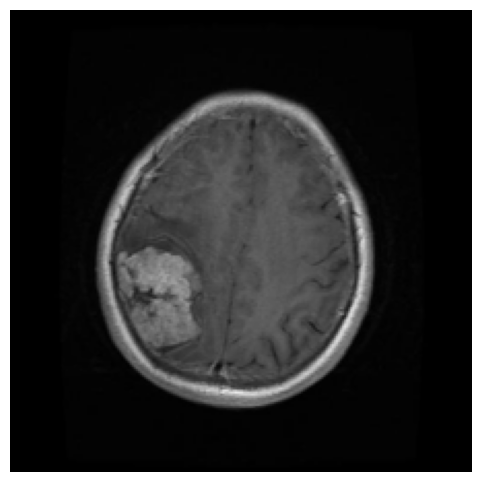

In [214]:
image = prepare_image("../assets/meningioma.jpg")

In [203]:
def get_conv_layers(model):
    convolution_layers = []

    for child in model.children():
        if isinstance(child, nn.Sequential):
            for layer in child:
                if isinstance(layer, nn.Conv2d):
                    convolution_layers.append(layer)

    return convolution_layers

In [251]:
def visualize_conv_layers(model, image: torch.Tensor, neuron: int, layer: int = -1):
    layers: list[nn.Conv2d] = get_conv_layers(model)
    feature_maps: list[torch.Tensor] = [image := layer(image) for layer in layers]

    if layer != -1:
        feature_map: torch.Tensor = feature_maps[layer]
        feature_map = F.relu(feature_map)
        feature_map: torch.Tensor = feature_map.squeeze(0)
        feature_map: np.ndarray = feature_map.detach().numpy()
        pl.imshow(feature_map[neuron], cmap="gray")
        pl.axis("off")
        return feature_maps

    if isinstance(model, VGG19):
        f, ax = pl.subplots(4, 4, figsize=(40, 40))
        pl.tight_layout()

        ix = 0

        for row in ax:
            for col in row:
                feature_map: torch.Tensor = feature_maps[ix]
                feature_map = F.relu(feature_map)
                feature_map: torch.Tensor = feature_map.squeeze(0)
                feature_map: np.ndarray = feature_map.detach().numpy()
                col.imshow(feature_map[neuron], cmap="gray")
                col.axis("off")
                ix += 1

    elif isinstance(model, CNN):
        f, ax = pl.subplots(1, 3, figsize=(30, 30))
        pl.tight_layout()

        ix = 0

        for x in ax:
            feature_map: torch.Tensor = feature_maps[ix]
            feature_map = F.relu(feature_map)
            feature_map: torch.Tensor = feature_map.squeeze(0)
            feature_map: np.ndarray = feature_map.detach().numpy()
            x.imshow(feature_map[neuron], cmap="gray")
            x.axis("off")
            ix += 1

    return feature_maps

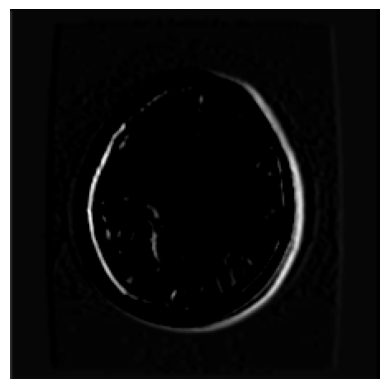

In [260]:
feature_maps = visualize_conv_layers(cnn, image, 8, 2)